## Simulating Rugby World Cup 23 Using Probabalistic Programming and Discrete Event Simulation

This notebook uses a combination of SAS and Python to:
- Ingest raw fixture results from HTML for international rugby union fixtures
- Prepare and reshape fixtures
- Build a hierarchical bayesian model for the win rate of sides
- Using the win rate posterior distributions as event probabilities in event based simulation
- Simulate pool stage and knock out fixtures
- Visualize this using SAS Visual Analytics

### Load Dependencies

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as BS
import swat
import json
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
plt.rcParams.max_subplots = 23

### Set Paths for Raw HTML Fixture Results

Here we open several HTML files to ingest and parse fixture results listed on rugbypass.com

In [3]:
''' for tier 1 sides who play many fixtures we only use 23/22 fixtures. the data for tier 2 sides is very sparse, with some sides playing only 1 fixture in a season '''
''' for these sides we ingest data from 21-19 and filter for only these sides '''
''' these sides are: georgia, fiji, samoa, uruguay, hong kong, romania,tonga,portugal, romania, spain, usa '''
data23 = 'raw_data\International Rugby Fixtures & Results _ International Rugby Scores, Schedules & Stats _ RugbyPass23.html'
data22 = 'raw_data\International Rugby Fixtures & Results _ International Rugby Scores, Schedules & Stats _ RugbyPass 22.html'
data21 = 'raw_data\International Rugby Fixtures & Results _ International Rugby Scores, Schedules & Stats _ RugbyPass_2021.html'
data20 = 'raw_data\International Rugby Fixtures & Results _ International Rugby Scores, Schedules & Stats _ RugbyPass2020.html'
data19 = 'raw_data\International Rugby Fixtures & Results _ International Rugby Scores, Schedules & Stats _ RugbyPass_2019.html'

### Define a Function to Parse Raw HTML Data

We parse the data using a custom function which reads the data using BS4. We extract the 'div' classes from the soups and then filter for 'game scores'. This is a class for games which have finished and we have a final score. We then iterate through each fixture to get key facts about the fixture.

In [4]:
''' This simple function scrapes HTML data from Rugby Pass and creates a Pandas DataFrame output'''
def parseFixtures(data):
    with open(data,encoding="utf8") as fp:
        soup = BS(fp,'html.parser')
    
    divs = soup.find_all('div',class_ = "game scores")
    num_games = len(divs)
    venue = []
    home_team = []
    away_team = []
    home_score = []
    away_score = []
   
    for i in range(num_games):
        res = divs[i]
        res_venue = res.find_all('div',class_='venue')[0].string
        try:
            res_home = res.find_all('div',class_='team home')[0].text
            res_away = res.find_all('div',class_='team away')[0].text
            res_score_home = res.find_all('div',class_='score home')[0].string
            res_score_away = res.find_all('div',class_='score away')[0].string
        except:
            res_home = ''
            res_away = ''
            res_score_home = 0
            res_score_away  = 0
        venue.append(res_venue)
        home_team.append(res_home)
        away_team.append(res_away)
        home_score.append(res_score_home)
        away_score.append(res_score_away)
       
    resdf = pd.DataFrame({'Venue':venue,'Home':home_team,'Away':away_team,'HomeScore':home_score,'AwayScore':away_score})
    return resdf

### Parse Raw HTML Files

Here we run the custom function on each HTML file and append a year to the output datasets so we can track how recent the observations are

In [5]:
fix23 = parseFixtures(data23)
fix22 = parseFixtures(data22)
fix21 = parseFixtures(data21)
fix20 = parseFixtures(data20)
fix19 = parseFixtures(data19)

fix23['Year'] = '2023'
fix22['Year'] = '2022'
fix21['Year'] = '2021'
fix20['Year'] = '2020'
fix19['Year'] = '2019'



We can see that some of the HTML files have leading and trailing line breaks which we need to tidy up

In [6]:
fix20.head()

,Venue,Home,Away,HomeScore,AwayScore,Year
0,\n Principality Stadium\n ...,\n\n\n\n Wales\n,\n\n\n\n Italy\n,42,0,2020
1,\n Aviva Stadium\n ...,\n\n\n\n Ireland\n,\n\n\n\n Scotland\n,19,12,2020
2,\n Stade De France\n ...,\n\n\n\n France\n,\n\n\n\n England\n,24,17,2020
3,\n Aviva Stadium\n ...,\n\n\n\n Ireland\n,\n\n\n\n Wales\n,24,14,2020
4,\n BT Murrayfield Stadium\n...,\n\n\n\n Scotland\n,\n\n\n\n England\n,6,13,2020


### Clean Records

Here we use some RegEx to replace the line breaks and strip trailing and leading spaces

In [7]:
fix23 = fix23.replace('\n','',regex=True)
fix22 = fix22.replace('\n','',regex=True)
fix21 = fix21.replace('\n','',regex=True)
fix20 = fix20.replace('\n','',regex=True)
fix19 = fix19.replace('\n','',regex=True)

In [8]:
fix23['Venue'] = fix23['Venue'].str.strip()
fix23['Home'] = fix23['Home'].str.strip()
fix23['Away'] = fix23['Away'].str.strip()

fix22['Venue'] = fix22['Venue'].str.strip()
fix22['Home'] = fix22['Home'].str.strip()
fix22['Away'] = fix22['Away'].str.strip()

fix21['Venue'] = fix21['Venue'].str.strip()
fix21['Home'] = fix21['Home'].str.strip()
fix21['Away'] = fix21['Away'].str.strip()

fix20['Venue'] = fix20['Venue'].str.strip()
fix20['Home'] = fix20['Home'].str.strip()
fix20['Away'] = fix20['Away'].str.strip()

fix19['Venue'] = fix19['Venue'].str.strip()
fix19['Home'] = fix19['Home'].str.strip()
fix19['Away'] = fix19['Away'].str.strip()

In [9]:
fix21.head()

,Venue,Home,Away,HomeScore,AwayScore,Year
0,Stadio Olimpico,Italy,France,10,50,2021
1,Twickenham,England,Scotland,6,11,2021
2,Principality Stadium,Wales,Ireland,21,16,2021
3,Twickenham,England,Italy,41,18,2021
4,BT Murrayfield,Scotland,Wales,24,25,2021


In [10]:
fix21[fix21['Home'].isin(['Italy','England'])]

,Venue,Home,Away,HomeScore,AwayScore,Year
0,Stadio Olimpico,Italy,France,10,50,2021
1,Twickenham,England,Scotland,6,11,2021
3,Twickenham,England,Italy,41,18,2021
6,Stadio Olimpico,Italy,Ireland,10,48,2021
8,Stadio Olimpico,Italy,Wales,7,48,2021
9,Twickenham,England,France,23,20,2021
23,Twickenham,England,USA,43,29,2021
31,Twickenham,England,Canada,70,14,2021
63,Stadio Olimpico,Italy,New Zealand,9,47,2021
64,Twickenham,England,Tonga,69,3,2021


The data now looks in a consistent and readable format, ready for pre-processing.

### Filter Years 21-19 for Tier 2 Sides

In order to capture recent form we use only data from 2022 until September 2023 to estimate team win rates. However, Tier 2 sides play fewer fixtures than Tier 1 sides. In order to bolster the number of observations of these sides we fetch data back to 2019 which was the last world cup. Here we filter 2019-2021 for the Tier 2 sides playing in the 2023 World Cup and merge them.

In [11]:
fix21_home_t2 = fix21[fix21['Home'].isin(['Georgia', 'Fiji', 'Samoa', 'Uruguay', 'Hong Kong', 'Romania','Tonga','Portugal', 'Spain', 'USA', 'Namibia', 'Chile'])]
fix21_away_t2 = fix21[fix21['Away'].isin(['Georgia', 'Fiji', 'Samoa', 'Uruguay', 'Hong Kong', 'Romania','Tonga','Portugal', 'Spain', 'USA', 'Namibia', 'Chile'])]

fix20_home_t2 = fix20[fix20['Home'].isin(['Georgia', 'Fiji', 'Samoa', 'Uruguay', 'Hong Kong', 'Romania','Tonga','Portugal', 'Spain', 'USA', 'Namibia', 'Chile'])]
fix20_away_t2 = fix20[fix20['Away'].isin(['Georgia', 'Fiji', 'Samoa', 'Uruguay', 'Hong Kong', 'Romania','Tonga','Portugal', 'Spain', 'USA', 'Namibia', 'Chile'])]

fix19_home_t2 = fix19[fix19['Home'].isin(['Georgia', 'Fiji', 'Samoa', 'Uruguay', 'Hong Kong', 'Romania','Tonga','Portugal', 'Spain', 'USA', 'Namibia', 'Chile'])]
fix19_away_t2 = fix19[fix19['Away'].isin(['Georgia', 'Fiji', 'Samoa', 'Uruguay', 'Hong Kong', 'Romania','Tonga','Portugal', 'Spain', 'USA', 'Namibia', 'Chile'])]


In [12]:
fix21_t2 = fix21_home_t2.append(fix21_away_t2)
fix20_t2 = fix20_home_t2.append(fix20_away_t2)
fix19_t2 = fix19_home_t2.append(fix19_away_t2)

C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/3746778381.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fix21_t2 = fix21_home_t2.append(fix21_away_t2)
C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/3746778381.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fix20_t2 = fix20_home_t2.append(fix20_away_t2)
C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/3746778381.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fix19_t2 = fix19_home_t2.append(fix19_away_t2)


### Merge Datasets

We now merge our dataframes to create one dataframe for Tier 1 fixtures (2022-2023) and Tier 2 fixtures (2019-2023)

In [13]:
fixtures = fix23.append(fix22).append(fix21_t2).append(fix20_t2).append(fix19_t2)

C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/2267819528.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fixtures = fix23.append(fix22).append(fix21_t2).append(fix20_t2).append(fix19_t2)
C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/2267819528.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fixtures = fix23.append(fix22).append(fix21_t2).append(fix20_t2).append(fix19_t2)
C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/2267819528.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fixtures = fix23.append(fix22).append(fix21_t2).append(fix20_t2).append(fix19_t2)


In [14]:
fixtures.head()

,Venue,Home,Away,HomeScore,AwayScore,Year
0,Principality Stadium,Wales,Ireland,10,34,2023
1,Twickenham,England,Scotland,23,29,2023
2,Stadio Olimpico,Italy,France,24,29,2023
3,Aviva Stadium,Ireland,France,32,19,2023
4,BT Murrayfield,Scotland,Wales,35,7,2023


In [15]:
fixtures.tail()

,Venue,Home,Away,HomeScore,AwayScore,Year
71,Fukuoka Hakatanomori Stadium,Ireland,Samoa,47,5,2019
73,Hanazono Rugby Stadium,USA,Tonga,19,31,2019
74,EGAO Kenko Stadium,Wales,Uruguay,35,13,2019
77,Hanazono Rugby Stadium,USA,Tonga,19,31,2019
78,Kumamoto Stadium,Wales,Uruguay,35,13,2019


### Visualize Fixtures

Let's have a look at our data. We can see that even with extra years of observations there is still an imbalance in the number of observations available for Tier 2 sides.

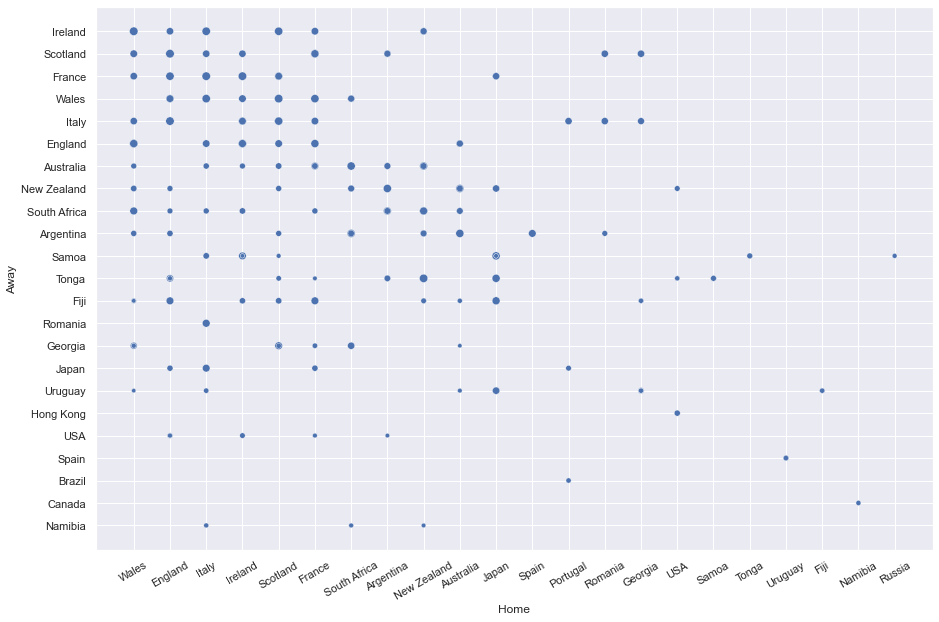

In [18]:
sns.set(rc={'figure.figsize':(15,10)})
g = sns.scatterplot(x=fixtures['Home'],y=fixtures['Away'],size=(fixtures['HomeScore']+fixtures['AwayScore']))
plt.xticks(rotation=30)
plt.legend([],[], frameon=False)

Whilst this plot is quite uninformative, it helps us to validate that sides who generally play few fixtures have now got at least 3 records for estimating win rate

### Create CAS Session

We're now going to do some pre-processing in SAS Viya. Here we make a connection to CAS and upload our dataframe for processing using PROC FEDSQL

In [19]:
# set environment details to make SAS connection
creds = pd.read_json('config.json')
user = creds['username'].values[0]
pwd = creds['password'].values[0]
cert = creds['cert'].values[0]
host = creds['host'].values[0]
os.environ['CAS_CLIENT_SSL_CA_LIST']  = cert

In [20]:
conn= swat.CAS(host, 443, user, pwd)

### Upload Validated Data

We can upload our dataframe as a CAS table and continue to interact with it from our Python session

In [21]:
fix_in = conn.upload_frame(fixtures,casout={'name':'fixtures','caslib':'casuser'})

c:\Users\sukhsn\anaconda3\lib\site-packages\swat\cas\connection.py:1650: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  data.to_csv(filename, encoding='utf-8',
c:\Users\sukhsn\anaconda3\lib\site-packages\swat\cas\connection.py:1483: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, value in df.dtypes.iteritems():


NOTE: Cloud Analytic Services made the uploaded file available as table FIXTURES in caslib CASUSER(sukhsn).
NOTE: The table FIXTURES has been created in caslib CASUSER(sukhsn) from binary data uploaded to Cloud Analytic Services.


In [22]:
fix_in.head()

,Venue,Home,Away,HomeScore,AwayScore,Year
0,Principality Stadium,Wales,Ireland,10,34,2023
1,Twickenham,England,Scotland,23,29,2023
2,Stadio Olimpico,Italy,France,24,29,2023
3,Kamaishi Recovery Memorial Stadium,Fiji,Uruguay,27,30,2019
4,Aviva Stadium,Ireland,France,32,19,2023


### Prepare Data for Modelling

We're going to start by using a DataStep to annote the fixtures with binary flags for which side won each fixture

In [23]:
conn.dataStep.runCode(''' 
data casuser.win_lose;
set casuser.fixtures;
if homescore gt awayscore then homewin = 1 ;
else homewin = 0 ;
if homewin =1 then awaywin = 0 ;
else awaywin = 1 ;
run;
''')

[InputCasTables]

             casLib      Name  Rows  Columns                                        casTable
 0  CASUSER(sukhsn)  fixtures   199        6  CASTable('fixtures', caslib='CASUSER(sukhsn)')

[OutputCasTables]

             casLib      Name  Rows  Columns  Append Promoted                                        casTable
 0  CASUSER(sukhsn)  win_lose   199        8     NaN        N  CASTable('win_lose', caslib='CASUSER(sukhsn)')

+ Elapsed: 0.03s, user: 0.0432s, sys: 0.0487s, mem: 42.9mb

In [24]:
win_lose = conn.CASTable('win_lose')

In [25]:
win_lose.head()

,Venue,Home,Away,HomeScore,AwayScore,Year,homewin,awaywin
0,Principality Stadium,Wales,Ireland,10,34,2023,0.0,1.0
1,Twickenham,England,Scotland,23,29,2023,0.0,1.0
2,Stadio Olimpico,Italy,France,24,29,2023,0.0,1.0
3,Kamaishi Recovery Memorial Stadium,Fiji,Uruguay,27,30,2019,0.0,1.0
4,Aviva Stadium,Ireland,France,32,19,2023,1.0,0.0


We'll now use FedSQL to get the number of wins at home or away and the number of fixtures played.

In [26]:
conn.loadactionset('fedSql')

NOTE: Added action set 'fedSql'.


[actionset]

 'fedSql'

+ Elapsed: 0.00128s, user: 0.00125s, mem: 0.241mb

In [27]:
conn.fedSql.execDirect(query=
'''
create table casuser.win_played as
select home,away,sum(homewin) as home_wins, count(home) as played, count(home)-sum(homewin) as away_wins from casuser.win_lose group by home, away
''')

NOTE: Table WIN_PLAYED was created in caslib CASUSER(sukhsn) with 122 rows returned.


+ Elapsed: 0.0745s, user: 0.16s, sys: 0.14s, mem: 248mb

In [28]:
win_played = conn.CASTable('win_played')

In [29]:
win_played.head()

,Home,Away,HOME_WINS,PLAYED,AWAY_WINS
0,Argentina,Tonga,2.0,2,0.0
1,England,New Zealand,0.0,1,1.0
2,England,South Africa,0.0,1,1.0
3,France,Italy,1.0,1,0.0
4,Georgia,Scotland,1.0,1,0.0


We can then use this to get the win rates for home and away as a simple fraction

In [30]:
conn.dataStep.runCode('''
data casuser.win_rates;
set casuser.win_played;
home_win_prop = home_wins / played ;
away_win_prop = away_wins / played;
run;
''')

[InputCasTables]

             casLib        Name  Rows  Columns                                          casTable
 0  CASUSER(sukhsn)  win_played   122        5  CASTable('win_played', caslib='CASUSER(sukhsn)')

[OutputCasTables]

             casLib       Name  Rows  Columns  Append Promoted                                         casTable
 0  CASUSER(sukhsn)  win_rates   122        7     NaN        N  CASTable('win_rates', caslib='CASUSER(sukhsn)')

+ Elapsed: 0.0266s, user: 0.0548s, sys: 0.0363s, mem: 47.9mb

In [31]:
win_rates = conn.CASTable('win_rates')
win_rates.tail()

,Home,Away,HOME_WINS,PLAYED,AWAY_WINS,home_win_prop,away_win_prop
117,Russia,Samoa,2.0,2.0,0.0,1.000000,0.000000
118,USA,New Zealand,1.0,1.0,0.0,1.000000,0.000000
119,New Zealand,Argentina,1.0,2.0,1.0,0.500000,0.500000
120,New Zealand,Tonga,1.0,1.0,0.0,1.000000,0.000000
121,South Africa,Wales,2.0,3.0,1.0,0.666667,0.333333


We're now going to do a bit of manipulation to create a bit more data for modelling. In a RWC we can assume that there is no home-advantage (except perhaps for the host team). Seeing as we're doing a hierarchical model for the team level win rate South Africa v Wales should be equivalent to Wales v South Africa. 

We're going to reshape the data to merge home_win_prop with away_win_prop by swapping Home and Away round

In [32]:
conn.fedSql.execDirect(query= '''
create table casuser.model_data_home as select Home as Home, Away as Away, home_win_prop as WinRate from casuser.win_rates
 ''')

NOTE: Table MODEL_DATA_HOME was created in caslib CASUSER(sukhsn) with 122 rows returned.


+ Elapsed: 0.0402s, user: 0.0569s, sys: 0.0436s, mem: 95.1mb

In [33]:
model_home = conn.CASTable('model_data_home')
model_home.head()

,HOME,AWAY,WINRATE
0,Argentina,Tonga,1.0
1,England,New Zealand,0.0
2,England,South Africa,0.0
3,France,Italy,1.0
4,Georgia,Scotland,1.0


In [34]:
conn.fedSql.execDirect(query= '''
create table casuser.model_data_away as select Away as Home,Home as Away, away_win_prop as WinRate from casuser.win_rates
 ''')

NOTE: Table MODEL_DATA_AWAY was created in caslib CASUSER(sukhsn) with 122 rows returned.


+ Elapsed: 0.041s, user: 0.042s, sys: 0.0592s, mem: 95.1mb

In [35]:
model_away = conn.CASTable('model_data_away')
model_away.head()

,HOME,AWAY,WINRATE
0,Tonga,Argentina,0.0
1,New Zealand,England,1.0
2,South Africa,England,1.0
3,Italy,France,0.0
4,Scotland,Georgia,0.0


### Export CAS Table to Data Frame for Modelling in PYMC

The probabalistic model, which estimates the underlying win rate of sides, is done using the Python library PYMC - which is a popular framework for probabalistic programming and Bayesian computation. Here we can download data from CAS back into local dataframes

In [36]:
model_away_df = model_away.to_frame()
model_home_df = model_home.to_frame()

In [37]:
model_data = model_home_df.append(model_away_df)

C:\Users\sukhsn\AppData\Local\Temp/ipykernel_24092/710428969.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_data = model_home_df.append(model_away_df)


In [38]:
model_data.shape

(244, 3)

In [39]:
model_data.head()

,HOME,AWAY,WINRATE
0,Argentina,Tonga,1.0
1,England,New Zealand,0.0
2,England,South Africa,0.0
3,France,Italy,1.0
4,Georgia,Scotland,1.0


In [40]:
model_data.tail()

,HOME,AWAY,WINRATE
117,Samoa,Russia,0.000000
118,New Zealand,USA,0.000000
119,Argentina,New Zealand,0.500000
120,Tonga,New Zealand,0.000000
121,Wales,South Africa,0.333333


### Define Indices for Teams and Matches

PYMC allows the creation of indices in order to track multi-dimensional data.

In [41]:
home_idx, teams = pd.factorize(model_data["HOME"], sort=True)
away_idx, _ = pd.factorize(model_data["AWAY"], sort=True)
coords = {"team": teams}

### Run MCMC Model to Estimate Win-Rates

Here we create a Markov Chain Monte Carlo (MCMC) model to estimate the win-rate at the team level. We want to estimate a distribution of values for win-rate across each team, we learn this as a hierarchical Bayesian model. 

The model is illustrated in the Directed Acyclic Graph (DAG) below. We have hyperpriors alpha & beta which are used for the prior Beta distribution for the win proportion `prop_win`. We then estimate probability of win as a Bernoulli random variable. We're not especially interested in `p_win` but it is what guides the estimation of `prop_win` since we have `prop_win` as the variable learned conditional on observations `WINRATE`.

In [46]:
with pm.Model(coords=coords) as model:
    home_team = pm.ConstantData('home_team',home_idx,dims='match')
    away_team = pm.ConstantData('away_team',away_idx,dims='match')
    alpha = pm.Gamma('alpha',alpha=4,beta=2)
    beta = pm.Gamma('beta',alpha=4,beta=2)
    prop_win = pm.Beta('prop_win',alpha=alpha,beta=beta,dims='team')
    p_win = pm.Bernoulli('p_win',p=prop_win[home_idx],observed=model_data['WINRATE'],dims=('match'))
    trace = pm.sample(15000,tune=15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, prop_win]


Sampling 4 chains for 15_000 tune and 15_000 draw iterations (60_000 + 60_000 draws total) took 105 seconds.


### Visualize DAG of MCMC Model

The below DAG shows how the model works. The benefit of the indices is that the Bernoulli variable is estimated at the fixture level, whilst `prop_win` is estimated at the individual team level

In [47]:
gv = pm.model_to_graphviz(model)

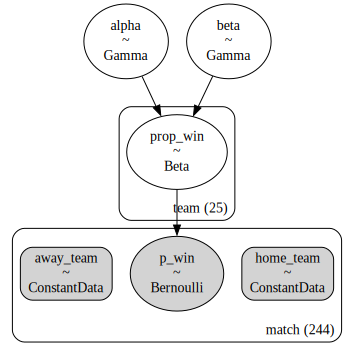

In [48]:
gv

### Visualize Energy Plot of Trace

The trace plot here gives us a high level understanding of how well (i.e. efficiently) the No-U-Turn (NUTS) sample is searching the parameter space. This trace plot doesn't look unreasonable, though there may be room for improvement. This is, after all, a quick and dirty model on sparse data!

<AxesSubplot: >

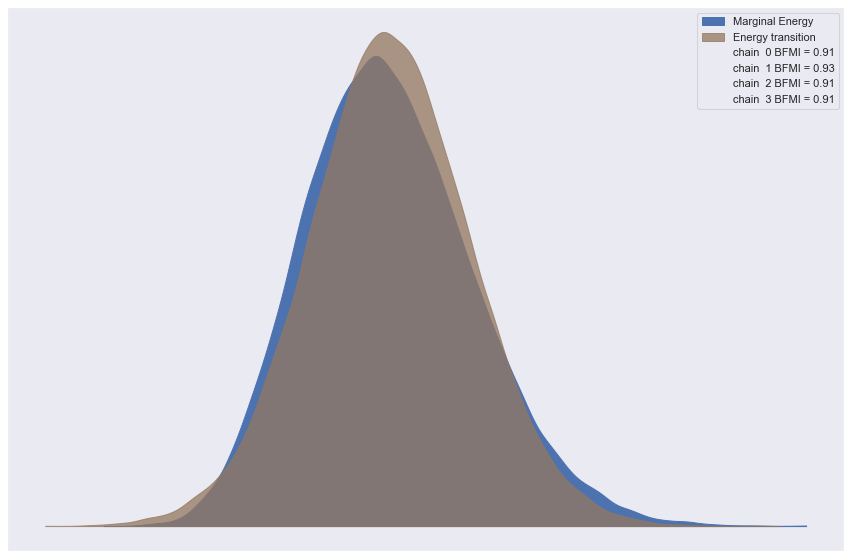

In [49]:
az.plot_energy(trace)

### Visualize Trace Plots 

The trace tells us what the estimated ranges are for the parameter estimates. Immediately we can see that Tier 2 sides appear to be overestimating performance - albeit with wider parameter ranges

In [50]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.512,0.692,1.320,3.826,0.004,0.003,30519.0,38960.0,1.0
beta,3.438,0.936,1.796,5.221,0.005,0.004,34037.0,39404.0,1.0
prop_win[Argentina],0.478,0.110,0.277,0.687,0.000,0.000,113448.0,44590.0,1.0
prop_win[Australia],0.358,0.103,0.177,0.558,0.000,0.000,101927.0,46111.0,1.0
prop_win[Brazil],0.357,0.177,0.038,0.671,0.001,0.000,82455.0,36841.0,1.0
prop_win[Canada],0.511,0.186,0.174,0.851,0.001,0.000,81537.0,42053.0,1.0
prop_win[England],0.355,0.096,0.178,0.536,0.000,0.000,82791.0,44783.0,1.0
prop_win[Fiji],0.345,0.117,0.134,0.565,0.000,0.000,98667.0,41135.0,1.0
prop_win[France],0.649,0.097,0.467,0.828,0.000,0.000,93125.0,43012.0,1.0
prop_win[Georgia],0.436,0.126,0.209,0.676,0.000,0.000,92662.0,42686.0,1.0


We can see that even with additional years of information, tier 2 sides play too infrequently to build reliable estimates of the team win rate

The below vertical line plot shows the High-Density Interval (HDI) of the parameter estimates for `prop_win`. It is clear that Tier 2 sides have very wider distributions, and on average likely over estimate performance. This may be due to shrinkage in the model, where population members which fall to the very top or bottom shrink towards the population mean. This is a characteristic of hierarchical Bayesian modelling in general. 

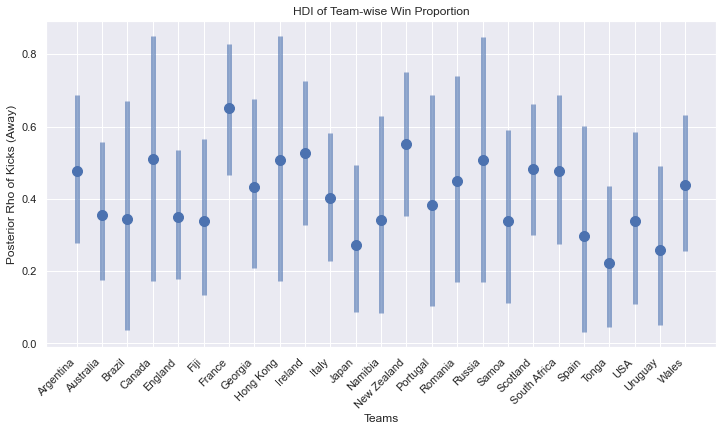

In [51]:
trace_hdi = az.hdi(trace)
trace_hdi["prop_win"]
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["prop_win"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["prop_win"].sel({"hdi": "lower"}),
    trace_hdi["prop_win"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
plt.xticks(rotation=45, ha='right') 
ax.set_ylabel("Posterior of Beta")
ax.set_title("HDI of Team-wise Win Proportion");

Tier 1 sides have a much tighter HDI interval, on average if we were to sample stochastically from the posterior we should find that tier 1 sides are on average expected to beat tier 2 sides

Looking at the trace plots, however, the caterpillar plots look reasonably stable and there appears to be pretty good mixing between chains of the MCMC sampler.

array([[<AxesSubplot: title={'center': 'prop_win\nArgentina'}>,
        <AxesSubplot: title={'center': 'prop_win\nArgentina'}>],
       [<AxesSubplot: title={'center': 'prop_win\nAustralia'}>,
        <AxesSubplot: title={'center': 'prop_win\nAustralia'}>],
       [<AxesSubplot: title={'center': 'prop_win\nBrazil'}>,
        <AxesSubplot: title={'center': 'prop_win\nBrazil'}>],
       [<AxesSubplot: title={'center': 'prop_win\nCanada'}>,
        <AxesSubplot: title={'center': 'prop_win\nCanada'}>],
       [<AxesSubplot: title={'center': 'prop_win\nEngland'}>,
        <AxesSubplot: title={'center': 'prop_win\nEngland'}>],
       [<AxesSubplot: title={'center': 'prop_win\nFiji'}>,
        <AxesSubplot: title={'center': 'prop_win\nFiji'}>],
       [<AxesSubplot: title={'center': 'prop_win\nFrance'}>,
        <AxesSubplot: title={'center': 'prop_win\nFrance'}>],
       [<AxesSubplot: title={'center': 'prop_win\nGeorgia'}>,
        <AxesSubplot: title={'center': 'prop_win\nGeorgia'}>],
    

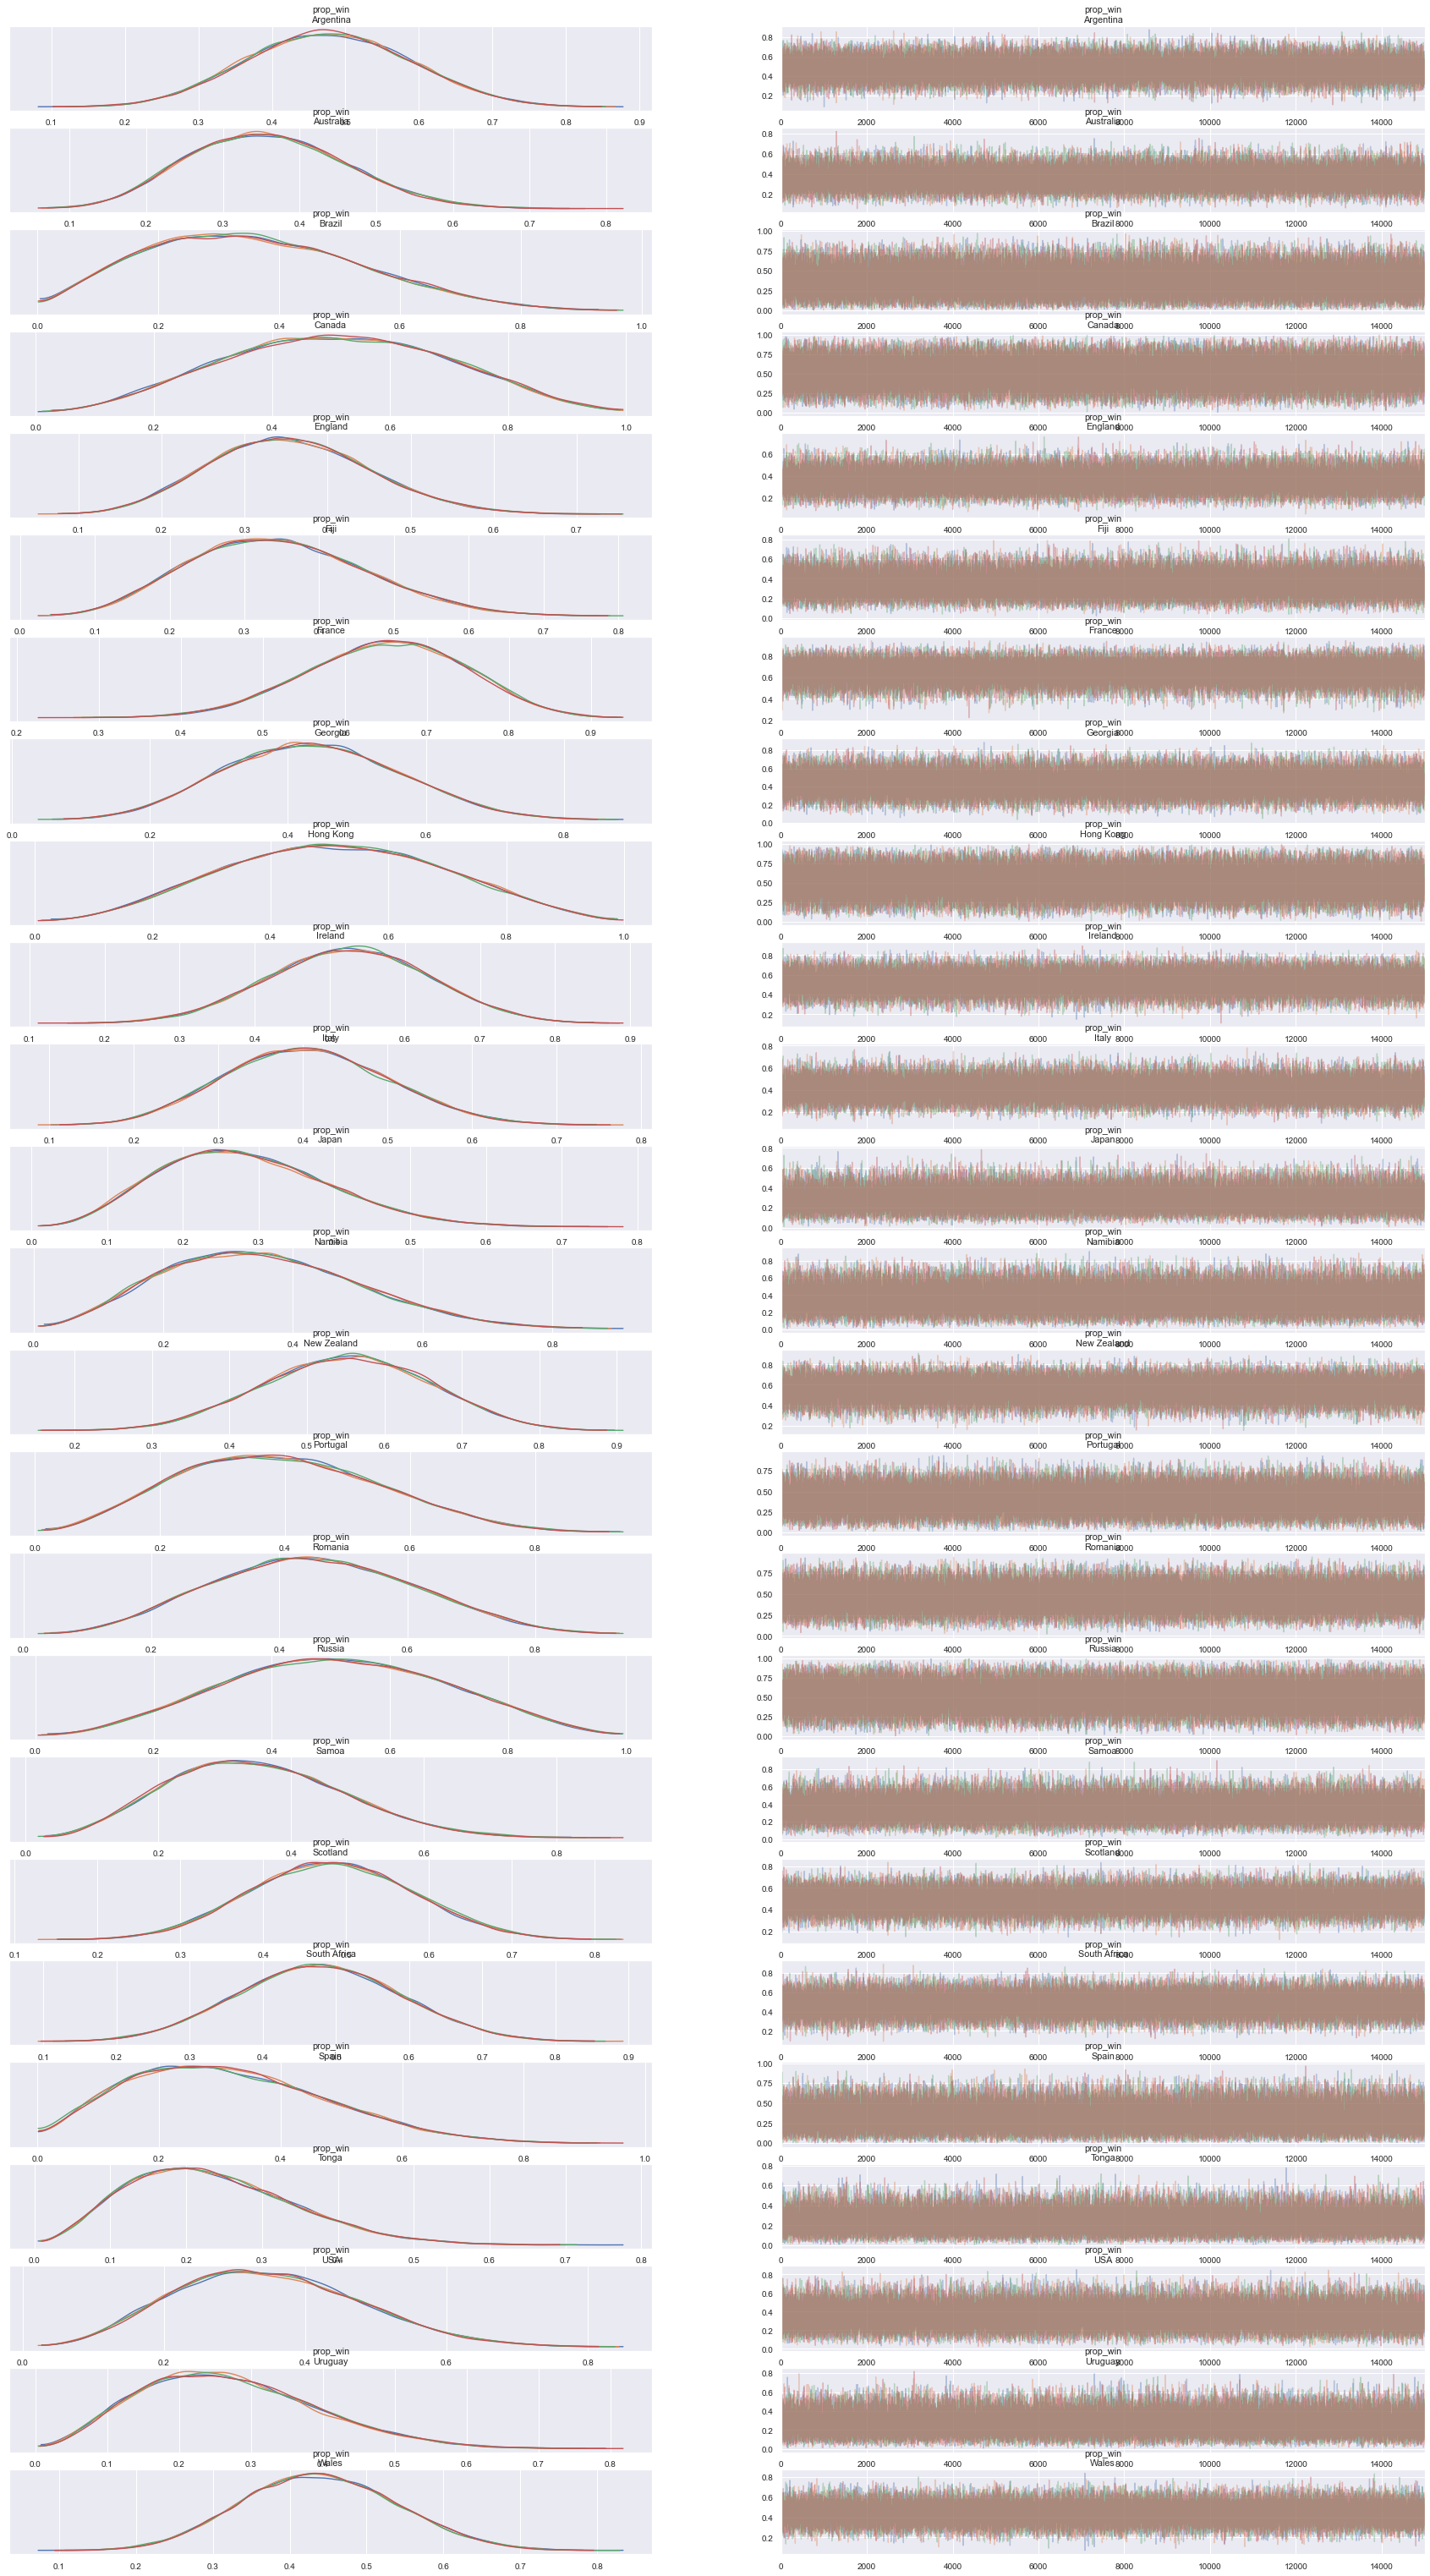

In [52]:
az.rcParams["plot.max_subplots"] = 200
az.plot_trace(trace,var_names=['prop_win'],compact=False,figsize=(30, 55)) # control fig size using mpl backend 

array([[<AxesSubplot: title={'center': 'alpha'}>,
        <AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'prop_win\nArgentina'}>],
       [<AxesSubplot: title={'center': 'prop_win\nAustralia'}>,
        <AxesSubplot: title={'center': 'prop_win\nBrazil'}>,
        <AxesSubplot: title={'center': 'prop_win\nCanada'}>],
       [<AxesSubplot: title={'center': 'prop_win\nEngland'}>,
        <AxesSubplot: title={'center': 'prop_win\nFiji'}>,
        <AxesSubplot: title={'center': 'prop_win\nFrance'}>],
       [<AxesSubplot: title={'center': 'prop_win\nGeorgia'}>,
        <AxesSubplot: title={'center': 'prop_win\nHong Kong'}>,
        <AxesSubplot: title={'center': 'prop_win\nIreland'}>],
       [<AxesSubplot: title={'center': 'prop_win\nItaly'}>,
        <AxesSubplot: title={'center': 'prop_win\nJapan'}>,
        <AxesSubplot: title={'center': 'prop_win\nNamibia'}>],
       [<AxesSubplot: title={'center': 'prop_win\nNew Zealand'}>,
        <AxesSubplot: title=

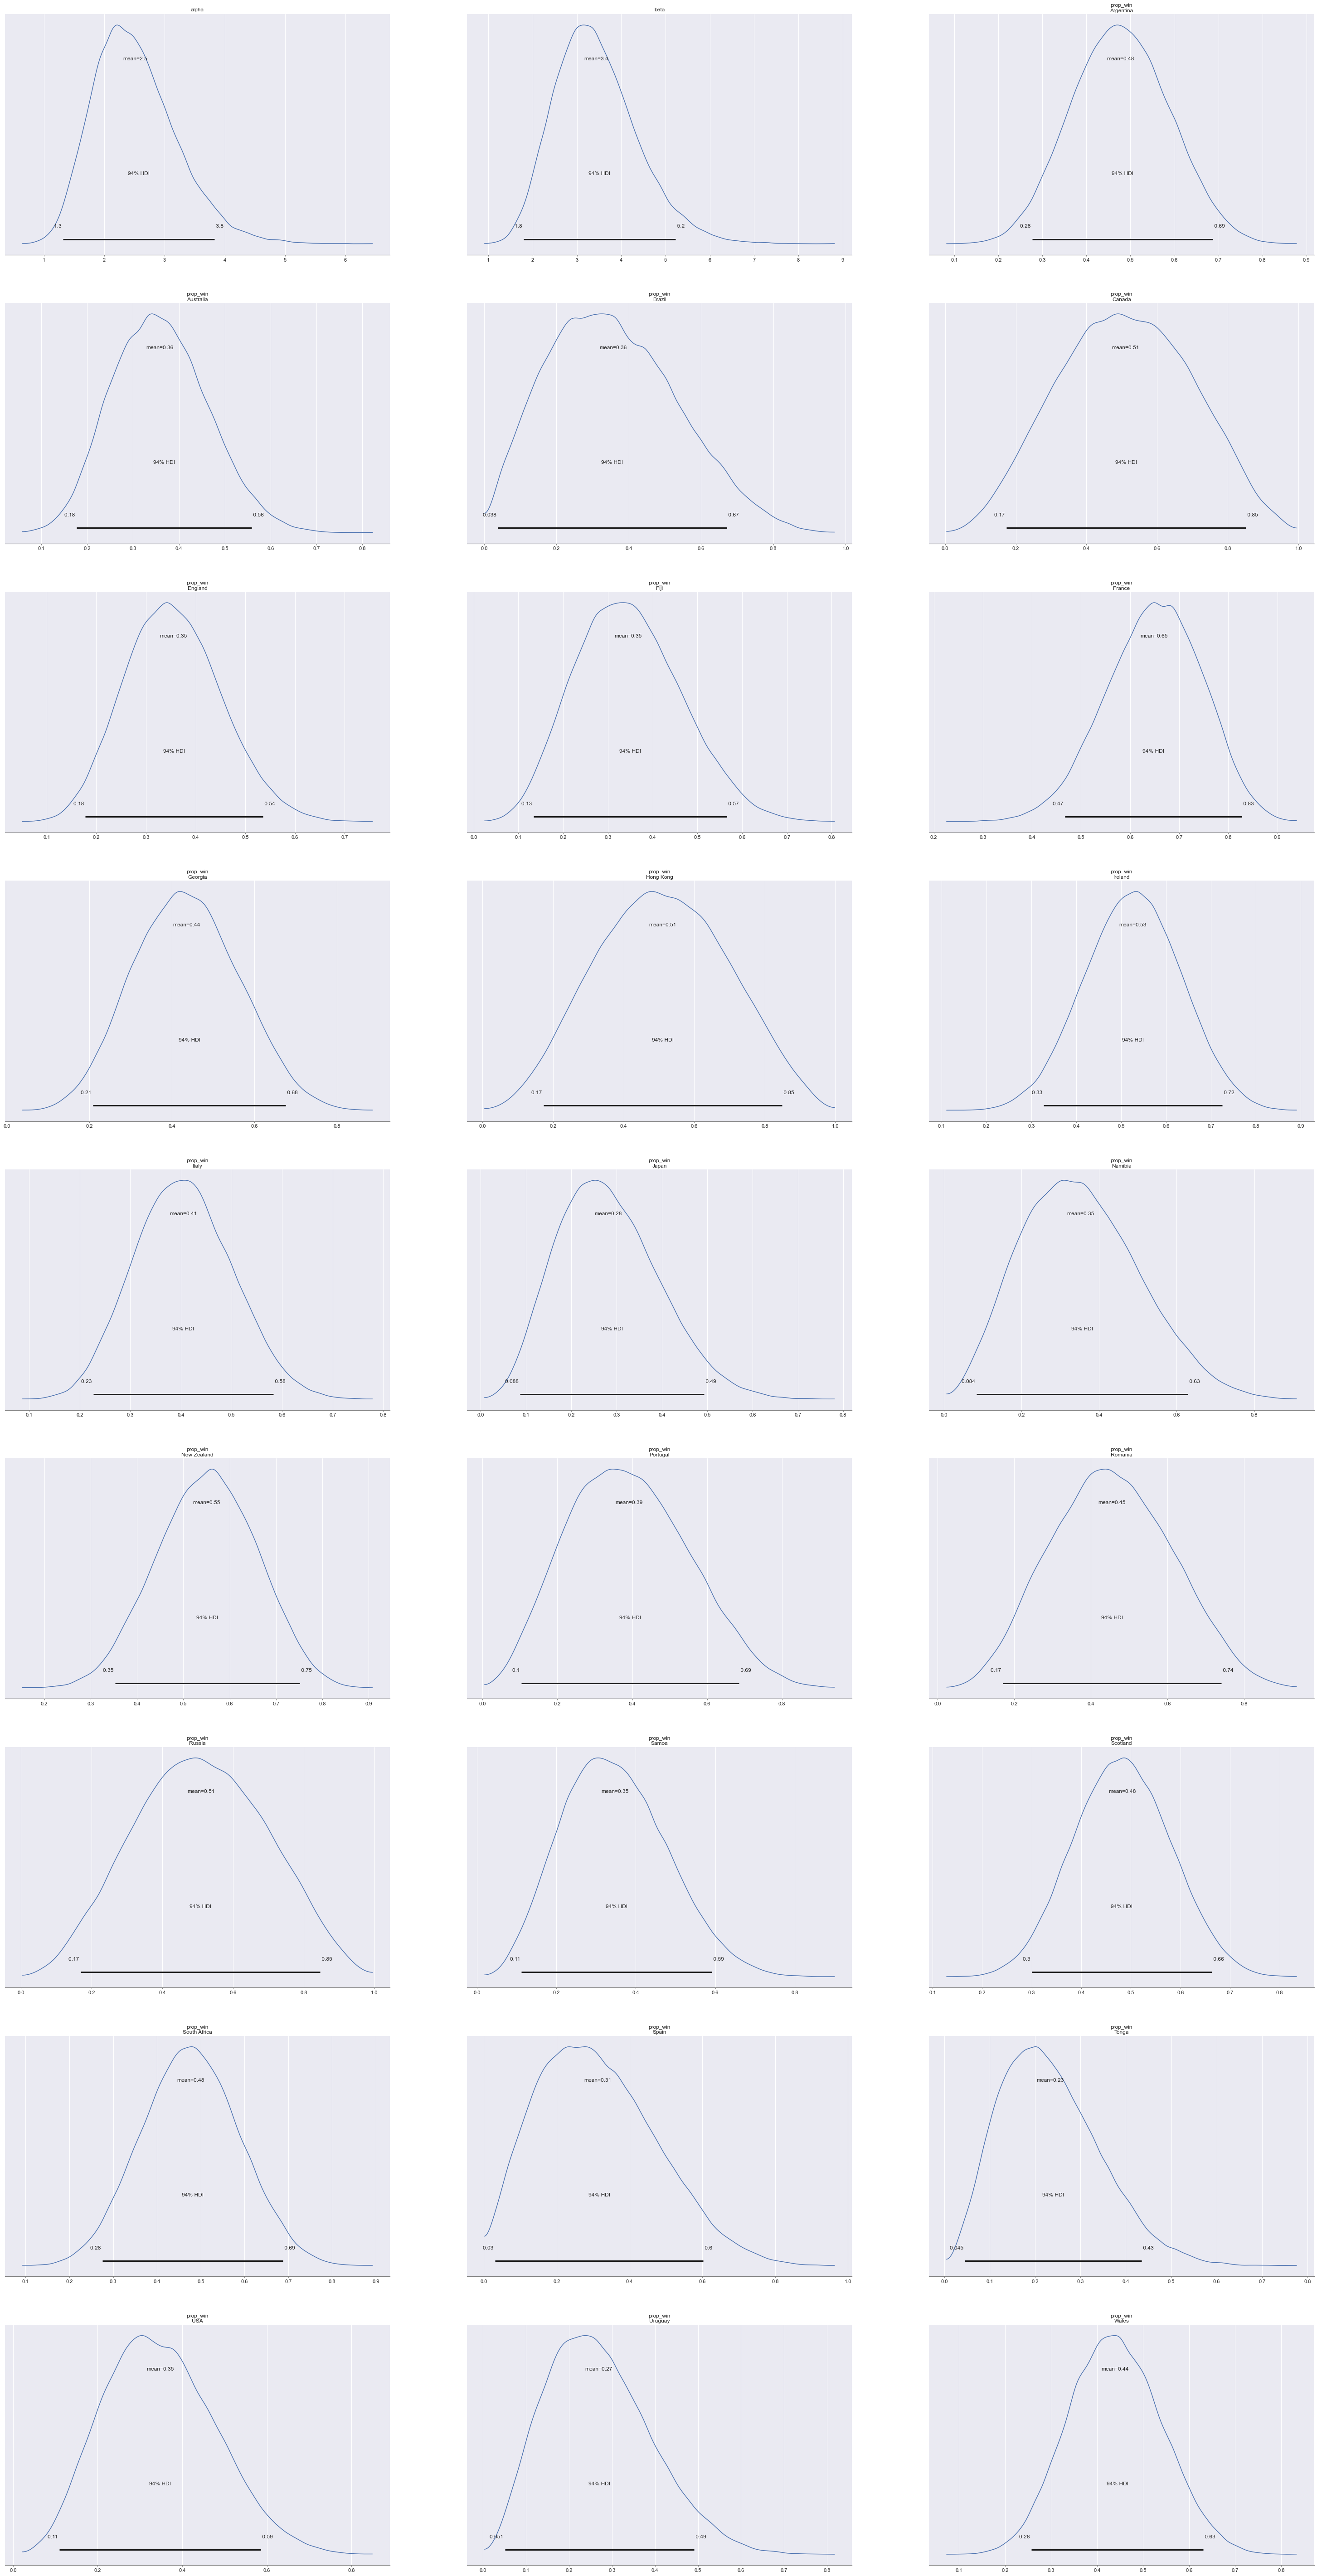

In [53]:
az.plot_posterior(trace)

### Create Dataframe of Posterior Win-Rates

We're now going to extract the 60,000 posterior samples for the win rate and load into a dataframe

In [54]:
prop_wins = trace['posterior']['prop_win'].to_dataframe().reset_index()

In [55]:
prop_wins.head()

,chain,draw,team,prop_win
0,0,0,Argentina,0.541398
1,0,0,Australia,0.309194
2,0,0,Brazil,0.460808
3,0,0,Canada,0.098753
4,0,0,England,0.352610


In order for this to be useful in the simulations, we're going to reshape the data so we have one column per team with 60,000 rows per team.

In [56]:
prop_wins = prop_wins[['team','prop_win']]

In [57]:
prop_wins.head()

,team,prop_win
0,Argentina,0.541398
1,Australia,0.309194
2,Brazil,0.460808
3,Canada,0.098753
4,England,0.352610


In [58]:
prop_wins.head()

,team,prop_win
0,Argentina,0.541398
1,Australia,0.309194
2,Brazil,0.460808
3,Canada,0.098753
4,England,0.352610


In [59]:
piv  = prop_wins.pivot(columns='team')

In [60]:
piv = piv.apply(lambda x: pd.Series(x.dropna().values))

### Where's Chile?!

Interestingly, there are no observations for Chile from international fixtures since 2019. Below we create a synthetic dataset for Chile as a proxy based on performance for similar Tier 2 sides. We can assume that Chile is likely to be overrespresented in the simulations given the lack of information we have available.


Story here: https://www.rugbyworldcup.com/2023/news/733127/rugby-world-cup-2023-americas-2-play-off-recap


In [61]:
piv.keys()

MultiIndex([('prop_win',    'Argentina'),
            ('prop_win',    'Australia'),
            ('prop_win',       'Brazil'),
            ('prop_win',       'Canada'),
            ('prop_win',      'England'),
            ('prop_win',         'Fiji'),
            ('prop_win',       'France'),
            ('prop_win',      'Georgia'),
            ('prop_win',    'Hong Kong'),
            ('prop_win',      'Ireland'),
            ('prop_win',        'Italy'),
            ('prop_win',        'Japan'),
            ('prop_win',      'Namibia'),
            ('prop_win',  'New Zealand'),
            ('prop_win',     'Portugal'),
            ('prop_win',      'Romania'),
            ('prop_win',       'Russia'),
            ('prop_win',        'Samoa'),
            ('prop_win',     'Scotland'),
            ('prop_win', 'South Africa'),
            ('prop_win',        'Spain'),
            ('prop_win',        'Tonga'),
            ('prop_win',          'USA'),
            ('prop_win',      'Uru

In [62]:
import xarray as xr

In [63]:
ds = xr.Dataset(piv)

In [64]:
teams = ['Argentina','Australia','Brazil','Canada', 'England', 'Fiji', 'France', 'Georgia', 'Hong Kong','Ireland','Italy', 'Japan', 'Namibia','New Zealand', 'Portugal', 'Romania','Russia','Samoa', 'Scotland', 'South Africa','Spain','Tonga','USA','Uruguay','Wales']

In [65]:
rates_df = pd.DataFrame()
for i in teams:
    rates_df[i] = ds[('prop_win',i)].values



In [66]:
rates_df.shape

(60000, 25)

In [67]:
rates_df.head()

,Argentina,Australia,Brazil,Canada,England,Fiji,France,Georgia,Hong Kong,Ireland,...,Romania,Russia,Samoa,Scotland,South Africa,Spain,Tonga,USA,Uruguay,Wales
0,0.541398,0.309194,0.460808,0.098753,0.352610,0.393259,0.729760,0.567672,0.604779,0.525106,...,0.709218,0.562257,0.462103,0.413860,0.467154,0.235921,0.153663,0.288536,0.214851,0.582891
1,0.496959,0.453379,0.317886,0.697932,0.340027,0.312970,0.569291,0.347652,0.427397,0.489341,...,0.267460,0.451406,0.187659,0.579839,0.493080,0.421169,0.279113,0.425227,0.271437,0.267484
2,0.469127,0.317524,0.472509,0.400918,0.426846,0.325667,0.805030,0.441978,0.487452,0.597734,...,0.577762,0.390251,0.606340,0.385969,0.503148,0.318420,0.278337,0.363073,0.278480,0.520611
3,0.507270,0.467169,0.508280,0.720563,0.349002,0.391703,0.566467,0.497841,0.576932,0.479864,...,0.508633,0.686185,0.133431,0.547028,0.460896,0.513560,0.271282,0.402835,0.355605,0.417296
4,0.462931,0.265598,0.379622,0.391522,0.336963,0.290006,0.744888,0.528401,0.364445,0.549892,...,0.432465,0.300444,0.196573,0.401078,0.396536,0.172033,0.227775,0.323250,0.396071,0.495462


In [68]:
rates_df['Chile'] = (rates_df['Brazil'] + rates_df['Canada'] + rates_df['Hong Kong'] +  rates_df['Portugal'] + rates_df['Spain'] + rates_df['Uruguay'] + rates_df['USA']) / 8

<AxesSubplot: xlabel='Chile', ylabel='Count'>

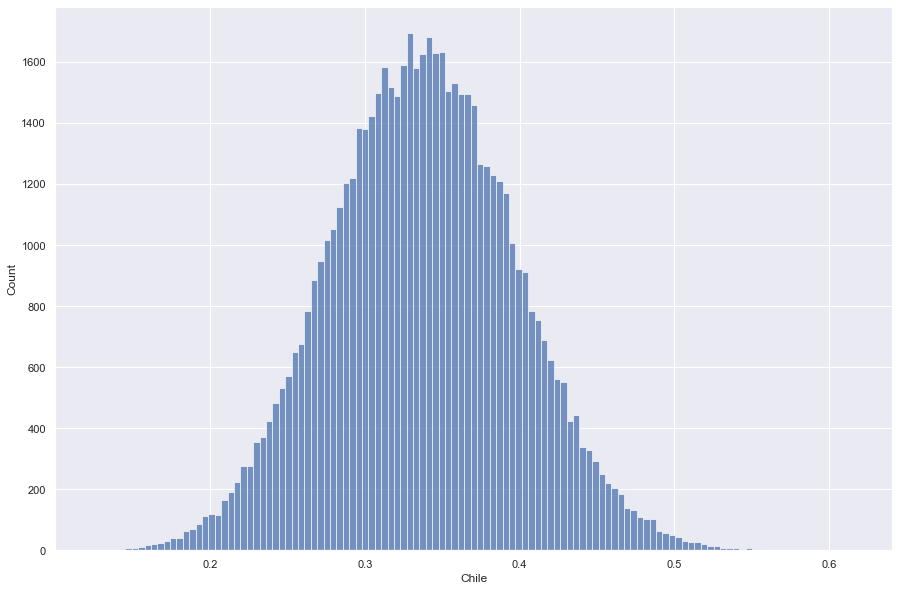

In [69]:
sns.histplot(rates_df['Chile'])

# Fixture Simulations using Random Sampling

Finally, we have our samples for win rate by team, including our proxy measure for Chile. Now we're able to start running simulations! Here we start by loading the fixture schedule for the Pool stages. We know that each of these fixtures will occur, with the top two from each pool then entering the knock-out stages.

### Load Fixtures for Pools

In [71]:
pool_fixtures = pd.read_csv('rwc_pool_fixtures.csv')

In [72]:
pool_fixtures

,Pool,Home,Away
0,A,France,New Zealand
1,A,Italy,Namibia
2,B,Ireland,Romania
3,C,Australia,Georgia
4,D,England,Argentina
5,D,Japan,Chile
6,B,South Africa,Scotland
7,C,Wales,Fiji
8,A,France,Uruguay
9,A,New Zealand,Namibia


### Illustrate logic

Below illustrates the logic that the simulation model runs through. For each fixture, and each side, a win probability is randomly sampled from our 60,000 samples from the posterior distributions for `prop_win`. We then compare the probability of side 1 winning versus the probability of side 2 winning. The side with the highest probability wins the fixture. We iterate through the tournament thusly. Once the pools are done we rank and select the top two sides, and then enter these sides into the knock-out stages. We use the same knock-out format as the real-life tournament. I.e. the winner of Pool C plays the runner-up of Pool D in the first quarter-final etc.

In [1]:
'''
- randomly sample win prob for each fixture in one go
- record sim iter
- calc home win and away win as binary
- sum wins by team by pool eg.g pool A - france = france home + france away wins
- rank 
- retain rank 1 and 2
- knock-out logic
    qf_1 = c_1 v d_2
    qf_2 = b_1 v a_2
    qf_3 = d_1 v c_2
    qf_4 = a_1 v b_2

    sf_1 = qf_1 v qf_2
    sf_2 = qf_3 v qf_4

    final = sf1 v sf2

    runnerup = sf1_loser v sf2_loser

- list top three places (gold,silver,bronze)
- return simulations as output df
- visualize pathways in VA 

'''

'\n- randomly sample win prob for each fixture in one go\n- record sim iter\n- calc home win and away win as binary\n- sum wins by team by pool eg.g pool A - france = france home + france away wins\n- rank \n- retain rank 1 and 2\n- knock-out logic\n    qf_1 = c_1 v d_2\n    qf_2 = b_1 v a_2\n    qf_3 = d_1 v c_2\n    qf_4 = a_1 v b_2\n\n    sf_1 = qf_1 v qf_2\n    sf_2 = qf_3 v qf_4\n\n    final = sf1 v sf2\n\n    runnerup = sf1_loser v sf2_loser\n\n- list top three places (gold,silver,bronze)\n- return simulations as output df\n- visualize pathways in VA \n\n'

### Create Simulation Function

Below we define the function which simulates the entire tournament including pool and knock-out stage. The function takes in the iteration number to help us track which iteration the results belong to. The function outputs a dataframe with the simulated results of the entire tournament.

In [83]:
def simulateRWC(sim_i):
    #print('begin simulation ',sim_i)
    # generate pool results
    pf = pool_fixtures.copy()

    pf['Home_Win_Prob'] = 0
    pf['Away_Win_Prob'] = 0
    pf['Home_Win'] = 0
    pf['Away_Win'] = 0

    for i in range(len(pf)):
        pf['Home_Win_Prob'][i] = rates_df[pf['Home'][i]].sample(n=1).values[0]
        pf['Away_Win_Prob'][i] = rates_df[pf['Away'][i]].sample(n=1).values[0]
        pf['Home_Win'][i] = pf['Home_Win_Prob'][i] > pf['Away_Win_Prob'][i]
        pf['Away_Win'][i] = pf['Away_Win_Prob'][i] > pf['Home_Win_Prob'][i]

    pf['Home_Win'] = pf['Home_Win'].astype(int)
    pf['Away_Win'] = pf['Away_Win'].astype(int)

    # post-process pool results
    xo = pf[['Pool','Home','Away','Home_Win','Away_Win']]
    xo_home = xo[['Pool','Home','Home_Win']].groupby(['Pool','Home']).sum('Home_Win').reset_index()
    xo_away = xo[['Pool','Away','Away_Win']].groupby(['Pool','Away']).sum('Away_Win').reset_index()
    xo_home = xo_home.rename(columns={'Home':'Team','Home_Win':'Wins'})
    xo_away = xo_away.rename(columns={'Away':'Team','Away_Win':'Wins'})

    # group wins by team and pool
    xo_out = xo_home.append(xo_away)
    xo_out = xo_out.groupby(['Pool','Team']).sum('Wins')

    # rank wins and select top two as pool winners
    xo_out.rank(method='dense',axis=0,ascending=False).sort_values(['Pool','Wins'])
    pool_winners  = xo_out.rank(method='dense',axis=0,ascending=False).sort_values(['Pool','Wins']).groupby(['Pool']).head(2)

    # generate quarter final results
    qf_df = pd.DataFrame()

    qf_df['fixture'] = ['','','','']
    qf_df['side_1'] = ['','','','']
    qf_df['side_2'] = ['','','','']
    qf_df['side1_win_prob'] = [0,0,0,0]
    qf_df['side2_win_prob'] = [0,0,0,0]

    for i in range(4):
        qf_df['fixture'][i] = 'quarter final ' + str(i+1)

    qf_df['side_1'][0] = pool_winners.loc['C'].reset_index().Team[0]
    qf_df['side_1'][1] = pool_winners.loc['B'].reset_index().Team[0]
    qf_df['side_1'][2] = pool_winners.loc['D'].reset_index().Team[0]
    qf_df['side_1'][3] = pool_winners.loc['A'].reset_index().Team[0]

    qf_df['side_2'][0] = pool_winners.loc['D'].reset_index().Team[1]
    qf_df['side_2'][1] = pool_winners.loc['A'].reset_index().Team[1]
    qf_df['side_2'][2] = pool_winners.loc['C'].reset_index().Team[1]
    qf_df['side_2'][3] = pool_winners.loc['B'].reset_index().Team[1]

    qf_df['side1_win'] = 0
    qf_df['side2_win'] = 0

    for i in range(len(qf_df)):
        qf_df['side1_win_prob'][i] = rates_df[qf_df['side_1'][i]].sample(n=1).values[0]
        qf_df['side2_win_prob'][i] = rates_df[qf_df['side_2'][i]].sample(n=1).values[0]
        qf_df['side1_win'][i] = qf_df['side1_win_prob'][i] > qf_df['side2_win_prob'][i]
        qf_df['side2_win'][i] = qf_df['side2_win_prob'][i] > qf_df['side1_win_prob'][i]

    qf_df['side1_win'] = qf_df['side1_win'].astype(int)
    qf_df['side2_win'] = qf_df['side2_win'].astype(int)

    # allocate winners of quarter final 
    if qf_df['side1_win'][0] > qf_df['side2_win'][0] :
        qf1_winner = qf_df['side_1'][0]
    else:
        qf1_winner = qf_df['side_2'][0]

    if qf_df['side1_win'][1] > qf_df['side2_win'][1] :
        qf2_winner = qf_df['side_1'][1]
    else:
        qf2_winner = qf_df['side_2'][1]

    if qf_df['side1_win'][2] > qf_df['side2_win'][2] :
        qf3_winner = qf_df['side_1'][2]
    else:
        qf3_winner = qf_df['side_2'][2]

    if qf_df['side1_win'][3] > qf_df['side2_win'][3] :
        qf4_winner = qf_df['side_1'][3]
    else:
        qf4_winner = qf_df['side_2'][3]

    # generate semi final results
    sf_df = pd.DataFrame()

    sf_df['fixture'] = ['','']
    sf_df['side_1'] = ['','']
    sf_df['side_2'] = ['','']
    sf_df['side1_win_prob'] = [0,0]
    sf_df['side2_win_prob'] = [0,0]

    for i in range(4):
        sf_df['fixture'][i] = 'semi final ' + str(i+1)

    sf_df['side_1'][0] = qf1_winner
    sf_df['side_1'][1] = qf3_winner
    sf_df['side_2'][0] = qf2_winner
    sf_df['side_2'][1] = qf4_winner

    sf_df['side1_win'] = 0
    sf_df['side2_win'] = 0

    for i in range(len(sf_df)):
        sf_df['side1_win_prob'][i] = rates_df[sf_df['side_1'][i]].sample(n=1).values[0]
        sf_df['side2_win_prob'][i] = rates_df[sf_df['side_2'][i]].sample(n=1).values[0]
        sf_df['side1_win'][i] = sf_df['side1_win_prob'][i] > sf_df['side2_win_prob'][i]
        sf_df['side2_win'][i] = sf_df['side2_win_prob'][i] > sf_df['side1_win_prob'][i]

    sf_df['side1_win'] = sf_df['side1_win'].astype(int)
    sf_df['side2_win'] = sf_df['side2_win'].astype(int)

    # allocate semi final winners and losers
    if sf_df['side1_win'][0] > sf_df['side2_win'][0] :
        sf1_winner = sf_df['side_1'][0]
        sf1_loser = sf_df['side_2'][0]
    else:
        sf1_winner = sf_df['side_2'][0]
        sf1_loser = sf_df['side_1'][0]

    if sf_df['side1_win'][1] > sf_df['side2_win'][1] :
        sf2_winner = sf_df['side_1'][1]
        sf2_loser = sf_df['side_2'][1]
    else:
        sf2_winner = sf_df['side_2'][1]
        sf2_loser = sf_df['side_1'][1]

    # generate final result
    final_side1 = sf1_winner
    final_side2 = sf2_winner
    final_side1_win_prob	= rates_df[final_side1].sample(n=1).values[0]
    final_side2_win_prob	= rates_df[final_side2].sample(n=1).values[0]
    final_side1_win = final_side1_win_prob > final_side2_win_prob
    final_side2_win = final_side2_win_prob > final_side1_win_prob

    if final_side1_win > final_side2_win:
        rwc_winner = final_side1
        rwc_second_place = final_side2
    else:
        rwc_winner = final_side2
        rwc_second_place = final_side1

    # create dataframe for rwc final
    rwc_winner_df = pd.DataFrame({'fixture':['RWC Final'],'side_1':[final_side1],'side_2':[final_side2],'side1_win_prob':	[final_side1_win_prob],'side2_win_prob':[final_side2_win_prob],	'side1_win': [final_side1_win] ,'side2_win':[final_side2_win]})

    # generate bronze result
    bronze_side1 = sf1_loser
    bronze_side2 = sf2_loser
    bronze_side1_win_prob	= rates_df[bronze_side1].sample(n=1).values[0]
    bronze_side2_win_prob	= rates_df[bronze_side2].sample(n=1).values[0]
    bronze_side1_win = bronze_side1_win_prob > bronze_side2_win_prob
    bronze_side2_win = bronze_side2_win_prob > bronze_side1_win_prob

    if bronze_side1_win > bronze_side2_win:
        rwc_bronze = bronze_side1
        rwc_fourth_place = bronze_side2
    else:
        rwc_bronze = bronze_side2
        rwc_fourth_place = bronze_side1

    # generate bronze df
    rwc_bronze_df = pd.DataFrame({'fixture':['RWC Bronze'],'side_1':[bronze_side1],'side_2':[bronze_side2],'side1_win_prob':	[bronze_side1_win_prob],'side2_win_prob':[bronze_side2_win_prob],	'side1_win': [bronze_side1_win] ,'side2_win':[bronze_side2_win]})

    # combine results
    all_sim1 = pf.rename(columns={'Pool':'Stage','Home':'Side1','Away':'Side2','Home_Win_Prob':'Side1_Win_Prob','Away_Win_Prob':'Side2_Win_Prob','Home_Win':'Side1_Win','Away_Win':'Side2_Win'})
    all_sim2 = qf_df.append(sf_df).append(rwc_bronze_df).append(rwc_winner_df).rename(columns={'fixture':'Stage','side_1':'Side1','side_2':'Side2','side1_win_prob':'Side1_Win_Prob','side2_win_prob':'Side2_Win_Prob','side1_win':'Side1_Win','side2_win':'Side2_Win'})

    all_sim = all_sim1.append(all_sim2)
    all_sim['Iteration'] = sim_i

    if sim_i % 500 == 0:
        print('simulation ',sim_i,'1st place:',rwc_winner,'2nd place:',rwc_second_place,'3rd place:',rwc_bronze,'semi-finalists',[qf1_winner,qf2_winner,qf3_winner,qf4_winner])

    # return simulation
    return all_sim


### Simulate RWC

Finally, we create a master dataframe to track all simulations. In a range of 20,000 simulations we iterate through this creating a complete RWC tournament per iteration. We then append the output dataframe to the master dataframe and continue the loop. For every 500th iteration we print tournament results to give an indication on how sensible the simulations look. It looks like France are favourites to win the tournament.

In [79]:
import warnings
warnings.filterwarnings("ignore")

In [84]:
master_sim = pd.DataFrame(columns=['Stage','Side1','Side2','Side1_Win_Prob','Side2_Win_Prob','Side1_Win','Side2_Win','Iteration'])

for i in range(20000):
    rwc_sim = simulateRWC(i)
    master_sim = master_sim.append(rwc_sim)

simulation  0 1st place: France 2nd place: Scotland 3rd place: Australia semi-finalists ['Australia', 'Scotland', 'Fiji', 'France']
simulation  500 1st place: France 2nd place: Ireland 3rd place: Australia semi-finalists ['England', 'Ireland', 'Australia', 'France']
simulation  1000 1st place: New Zealand 2nd place: France 3rd place: Georgia semi-finalists ['Georgia', 'New Zealand', 'Wales', 'France']
simulation  1500 1st place: France 2nd place: Italy 3rd place: Wales semi-finalists ['Argentina', 'Italy', 'Wales', 'France']
simulation  2000 1st place: Ireland 2nd place: Wales 3rd place: South Africa semi-finalists ['Wales', 'South Africa', 'Georgia', 'Ireland']
simulation  2500 1st place: France 2nd place: New Zealand 3rd place: Georgia semi-finalists ['Wales', 'France', 'Georgia', 'New Zealand']
simulation  3000 1st place: Ireland 2nd place: Argentina 3rd place: France semi-finalists ['Samoa', 'Ireland', 'Argentina', 'France']
simulation  3500 1st place: France 2nd place: New Zealand

In [85]:
master_sim.shape

(960000, 8)

### Upload Final Simulations into CAS

We're now able to upload our 20,000 simulations directly back into CAS. Once the data is uploaded we do some post-processing in SAS Studio and then visualize our results in SAS Visual Analytics.

In [89]:
conn.upload_frame(master_sim,casout={'name':'rwc23_sim_hs','caslib':'public','promote':True})

NOTE: Cloud Analytic Services made the uploaded file available as table RWC23_SIM_HS in caslib public.
NOTE: The table RWC23_SIM_HS has been created in caslib public from binary data uploaded to Cloud Analytic Services.


CASTable('RWC23_SIM_HS', caslib='public')

In [86]:
master_sim.to_csv('final_rwc_sim.csv',index=False)